In [1]:
using NBInclude
@nbinclude("Kagome SP.ipynb")

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423


get_SP_H (generic function with 1 method)

In [2]:
using QuantumOptics

# https://juliapackages.com/p/einsum
using Einsum

using BenchmarkTools

using LinearAlgebra

In [108]:
Nx = 5; Ny = 5; N=Nx*Ny*3; cut_off = 5
PN = [0,1,2,3]
U = 0.001
# t1=-1;L1=0 ;t2=L2=0
# t1=L1=0;t2=L2=-1
t1 = -1;L1 = 0.28;t2 = 0.3;L2 = 0.2;
# t1=t2=-1;L1=L2=0

0.2

In [4]:
sp_basis = NLevelBasis(N)
sp_matrix = get_SP_H(Nx, Ny, t1, L1, t2, L2);

In [5]:
function get_sp_op(sp_basis, sp_matrix)
  
    H = SparseOperator(sp_basis)

    for m in 1:N
        for n in 1:N
            H += sp_matrix.data[m,n] * transition(sp_basis, m, n)
        end
    end
    
    return H
end

get_sp_op (generic function with 1 method)

In [6]:
H1 = get_sp_op(sp_basis, sp_matrix);

In [7]:
#check operator form
eigenenergies(dense(H1)) == eigenenergies(dense(sp_matrix))

true

In [8]:
function get_sub_states(sp_op, cut_off)
    
    E0, states0 = eigenstates(dense(sp_op))
    states = states0[1:cut_off]
    
    return states
end

get_sub_states (generic function with 1 method)

In [9]:
sub_states = get_sub_states(H1, cut_off);

In [10]:
function get_projector_op(states, basis)
    
    b_sub = SubspaceBasis(basis,states)
    P = projector(b_sub, basis)
    Pt = dagger(P)
    
    return b_sub, P, Pt
end

get_projector_op (generic function with 1 method)

In [11]:
b_sub, P, Pt = get_projector_op(sub_states, sp_basis);

In [12]:
function get_subspace_op(sp_op, P, Pt)
    return P*sp_op*Pt
end

get_subspace_op (generic function with 1 method)

In [13]:
H1_sub = get_subspace_op(H1, P, Pt);

In [14]:
states_mb = bosonstates(b_sub, PN) 
basis_mb = ManyBodyBasis(b_sub, states_mb);

In [15]:
function get_mb_op(basis_mb, basis, sp_op)
    
    Op_MB = SparseOperator(basis_mb)
    
    for i in 1:length(basis)
        for j in 1:length(basis)
            Op_MB += sp_op.data[i,j] * transition(basis_mb, i, j)
        end
    end
    
    return Op_MB
end

get_mb_op (generic function with 1 method)

In [16]:
H1_MB = get_mb_op(basis_mb, b_sub, H1_sub);

In [17]:
@nbinclude("Kagome MB .ipynb"; regex=r"#.*executeme")

Kagome_Finite_U (generic function with 1 method)

In [18]:
function get_hubbard_int(P, Pt, b_sub, cut_off)
    
    bcut_mb = get_Bosonic_MB_Basis(cut_off, PN)
    
    @time begin
    P1 = P.data
    P1t = Pt.data;

    @einsum P4[k,l,m,n] := P1[k,i] * P1[l,i] * P1t[i,m] * P1t[i,n]

    Vint_mb_cut = SparseOperator(bcut_mb)
        
    for k in 1:cut_off
        for l in 1:cut_off
            for m in 1:cut_off
                for n in 1:cut_off
                    a1t = create(bcut_mb, k)
                    a2t = create(bcut_mb, l)
                    a2  = destroy(bcut_mb, m)      
                    a1  = destroy(bcut_mb, n)      
                    Vint_mb_cut += U/2*P4[k,l,m,n]*a1t*a2t*a2*a1
                end
            end
        end
    end
    end
    
    return Vint_mb_cut
end

get_hubbard_int (generic function with 1 method)

In [19]:
H1_Int = get_hubbard_int(P, Pt, b_sub, cut_off);

  0.395485 seconds (500.17 k allocations: 51.464 MiB, 91.48% compilation time)


In [20]:
bcut_mb = get_Bosonic_MB_Basis(cut_off,PN)
H1cut = SparseOperator(bcut_mb)
H1cut.data = H1_MB.data
H_MB = H1cut + H1_Int;

In [21]:
using DataFrames

function get_energies(pn, Energies, states, basis)
    PN_Energies = Array{Float64}(undef, length(states[1]), 2)
    for i in 1:length(Energies)
        PN_Energies[i] = round(expect(number(basis), states[i])) #expected values (first column)
        PN_Energies[i,2] = E[i] #eigen-values (second column)
    end
    df = DataFrame(PN_Energies, :auto)
    df = filter(row -> (row.x1 == pn),  df)
    
    return df
end

get_energies (generic function with 1 method)

In [22]:
pn = 3
E, S = eigenstates(dense(dense((H_MB+dagger(H_MB))/2)))
get_energies(pn, E, S, bcut_mb)

,x1,x2
,Float64,Float64
1,3.0,-8.39996
2,3.0,-8.37437
3,3.0,-8.37437
4,3.0,-8.37437
5,3.0,-8.37437
6,3.0,-8.3488
7,3.0,-8.34879
8,3.0,-8.34879
9,3.0,-8.34879


# Density-Profile

In [23]:
function get_num_sub_list(sp_basis, P, Pt)
    num_sub_list = []
    for m in 1:N
        NM = transition(sp_basis, m, m)
        NMP = get_subspace_op(NM, P, Pt)
        push!(num_sub_list, NMP)
    end
    return num_sub_list
end

get_num_sub_list (generic function with 1 method)

In [24]:
num_sub_list = get_num_sub_list(sp_basis,P,Pt);

In [25]:
function get_mb_op(basis_mb, basis, sp_op)
    
    Op_MB = SparseOperator(basis_mb)
    
    for i in 1:length(basis)
        for j in 1:length(basis)
            Op_MB += sp_op.data[i,j] * transition(basis_mb, i, j)
        end
    end
    
    return Op_MB
end

get_mb_op (generic function with 1 method)

In [26]:
function get_num_mb_list(basis_mb, basis, num_sub_list)
    
    num_mb_list = []
    
    for m in 1:N
        NMP = get_mb_op(basis_mb, basis, num_sub_list[m])
        push!(num_mb_list, NMP)
    end
    
    return num_mb_list
end

get_num_mb_list (generic function with 1 method)

In [27]:
num_mb_list = get_num_mb_list(basis_mb, b_sub, num_sub_list);

## num_mb_list[i] & number(bcut_mb,i)

In [94]:
num_mb_list[21] #num 21

Operator(dim=56x56)
  basis: ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=48), states:5), states:56)sparse([2, 3, 4, 5, 6, 2, 3, 4, 5, 6  …  51, 52, 54, 55, 56, 36, 46, 52, 55, 56], [2, 2, 2, 2, 2, 3, 3, 3, 3, 3  …  55, 55, 55, 55, 55, 56, 56, 56, 56, 56], ComplexF64[0.02083333333333677 + 0.0im, 0.02434771592652171 - 0.014300956203994im, 0.00141509808154258 + 0.00082916494984738im, -0.0194894041552408 - 0.01105566925726306im, 0.00528383030426468 + 0.00498833530899649im, 0.02434771592652171 + 0.014300956203994im, 0.03827177372097706 + 0.0im, 0.00108463461426752 + 0.00194042536049291im, -0.01518796003655812 - 0.02629907566652964im, 0.00275093925443414 + 0.00945688304737332im  …  0.00078833632930482 - 0.00018177623461874im, -0.00176382681003412 - 2.472357421504e-5im, -0.0151802966023766 + 0.00372512665376931im, 0.02916813123507372 + 0.0im, -0.01314652249464073 - 0.00322605431447874im, 0.00915186254555854 - 0.00864005020037171im, 0.00476476655721558 - 0.01637980191928738im, 0.0009655

In [95]:
number(bcut_mb,5) #num 5

Operator(dim=56x56)
  basis: ManyBody(onebodybasis=NLevel(N=5), states:56)sparse([6, 11, 15, 18, 20, 21, 26, 30, 33, 35  …  40, 43, 45, 46, 49, 51, 52, 54, 55, 56], [6, 11, 15, 18, 20, 21, 26, 30, 33, 35  …  40, 43, 45, 46, 49, 51, 52, 54, 55, 56], ComplexF64[1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 2.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im  …  1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 2.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 2.0 + 0.0im, 1.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im], 56, 56)

## Error (IT DOESN'T WORK?)

In [97]:
typeof(dense(num_mb_list[1]))

Operator{ManyBodyBasis{Vector{Int64}, SubspaceBasis{Vector{Int64}, NLevelBasis{Int64}, Ket{NLevelBasis{Int64}, Vector{ComplexF64}}, 0x6e89b9c05d6b6b3a, UInt64}, 0xbfa4cc919ddd872b, UInt64}, ManyBodyBasis{Vector{Int64}, SubspaceBasis{Vector{Int64}, NLevelBasis{Int64}, Ket{NLevelBasis{Int64}, Vector{ComplexF64}}, 0x6e89b9c05d6b6b3a, UInt64}, 0xbfa4cc919ddd872b, UInt64}, Matrix{ComplexF64}}

In [98]:
typeof(S[1])

Ket{ManyBodyBasis{Vector{Int64}, NLevelBasis{Int64}, 0xbfa4cc919ddd872b, UInt64}, Vector{ComplexF64}}

In [99]:
expect(num_mb_list[1],Ket(bcut_mb,S[1]))

LoadError: MethodError: no method matching expect(::Operator{ManyBodyBasis{Vector{Int64}, SubspaceBasis{Vector{Int64}, NLevelBasis{Int64}, Ket{NLevelBasis{Int64}, Vector{ComplexF64}}, 0x6e89b9c05d6b6b3a, UInt64}, 0xbfa4cc919ddd872b, UInt64}, ManyBodyBasis{Vector{Int64}, SubspaceBasis{Vector{Int64}, NLevelBasis{Int64}, Ket{NLevelBasis{Int64}, Vector{ComplexF64}}, 0x6e89b9c05d6b6b3a, UInt64}, 0xbfa4cc919ddd872b, UInt64}, SparseArrays.SparseMatrixCSC{ComplexF64, Int64}}, ::Ket{ManyBodyBasis{Vector{Int64}, NLevelBasis{Int64}, 0xbfa4cc919ddd872b, UInt64}, Ket{ManyBodyBasis{Vector{Int64}, NLevelBasis{Int64}, 0xbfa4cc919ddd872b, UInt64}, Vector{ComplexF64}}})
[0mClosest candidates are:
[0m  expect(::AbstractOperator, [91m::Vector[39m) at C:\Users\Can\.julia\packages\QuantumOpticsBase\iQrMn\src\operators.jl:301
[0m  expect(::DataOperator{B, B}, [91m::Ket{B}[39m) where B at C:\Users\Can\.julia\packages\QuantumOpticsBase\iQrMn\src\operators_dense.jl:208
[0m  expect(::AbstractOperator{B, B}, [91m::Ket{B}[39m) where B at C:\Users\Can\.julia\packages\QuantumOpticsBase\iQrMn\src\operators.jl:279
[0m  ...

## Version Check

In [100]:
using Pkg
Pkg.status()

      Status `C:\Users\Can\.julia\environments\v1.7\Project.toml`
  [7d9fca2a] Arpack v0.5.4
  [6e4b80f9] BenchmarkTools v1.3.2
  [ada6cbde] Bravais v0.1.5
  [23470ee3] Brillouin v0.5.6
  [34da2185] Compat v3.45.0
  [a93c6f00] DataFrames v1.3.3
  [b7d42ee7] Einsum v0.4.1
  [7073ff75] IJulia v1.23.2
  [c21dee59] Lattices v0.1.0
  [23992714] MAT v0.10.3
  [0db19996] NBInclude v2.3.0
  [b8a86587] NearestNeighbors v0.4.10
  [645ca80c] Neighborhood v0.2.3
  [6fe1bfb0] OffsetArrays v1.10.8
  [f0f68f2c] PlotlyJS v0.18.8
  [91a5bcdd] Plots v1.27.1
  [438e738f] PyCall v1.95.1
  [d330b81b] PyPlot v2.10.0
  [6e0679c1] QuantumOptics v1.0.3
  [db00978d] TightBinding v0.1.3
  [770da0de] UpdateJulia v0.4.0


## nm_mb_list -> NM_MB_Matrix -> Operator (IT WORK!)

In [28]:
NM_MB_Array_Storage = zeros(Complex{Float64},length(bcut_mb),length(bcut_mb),N);
NM_MB_Matrix = zeros(Complex{Float64},length(bcut_mb),length(bcut_mb));
for m in 1:N
    for i in 1:length(bcut_mb)
        for j in 1:length(bcut_mb)
            NM_MB_Matrix[i,j] = num_mb_list[m].data[i,j]
        end
    end
    NM_MB_Array_Storage[:,:,m] = NM_MB_Matrix
end
BL = BR = bcut_mb
index_number_op = 6
T = NM_MB_Array_Storage[:,:,index_number_op]
Op = Operator(BL,BR,T);
expect(Op, S[1])

0.03999999913304204 + 5.3761287751095486e-21im

In [29]:
PN

4-element Vector{Int64}:
 0
 1
 2
 3

In [30]:
index_eig_states = 3
Sum = 0
expect_list=[]
for i in 1:N
    T = NM_MB_Array_Storage[:,:,i]
    Op = Operator(BL,BR,T)
    Sum += expect(Op, S[index_eig_states])
    println(i,"\t",expect(Op, S[index_eig_states]))
    push!(expect_list,expect(Op, S[index_eig_states]))
end
print("Max occ. number:", Sum)

1	0.03276073762274579 + 3.2260953852865373e-18im
2	0.04964175104634896 + 2.088994773521371e-18im
3	0.028454034061014526 + 2.8811802177906357e-18im
4	0.03513325046452836 + 1.1761099680082013e-18im
5	0.037102185579949855 - 1.049116983686641e-18im
6	0.03251758537821768 - 8.1004338027459955e-19im
7	0.034635357606109786 + 1.5701520157002609e-18im
8	0.035283178411265465 + 1.1321931947601336e-18im
9	0.033677686721954675 - 2.602810522115449e-19im
10	0.05108839524803562 - 1.9704763741288643e-18im
11	0.035792787409430774 + 8.987563958608763e-19im
12	0.06533496795506316 + 1.5059047165775082e-18im
13	0.027176991952796464 + 1.0422297963193742e-18im
14	0.05395109808180051 - 7.169087062668375e-19im
15	0.06118555847625529 - 5.501107736955661e-18im
16	0.029842517220198768 - 8.89736792612204e-20im
17	0.04878832889942881 - 1.9345889267645753e-18im
18	0.03756806947152915 - 1.1350016991219499e-18im
19	0.0303987520150631 + 8.020386561477991e-19im
20	0.05533194351505958 - 1.4382773377520137e-18im
21	0.036519

# Kagome Plot

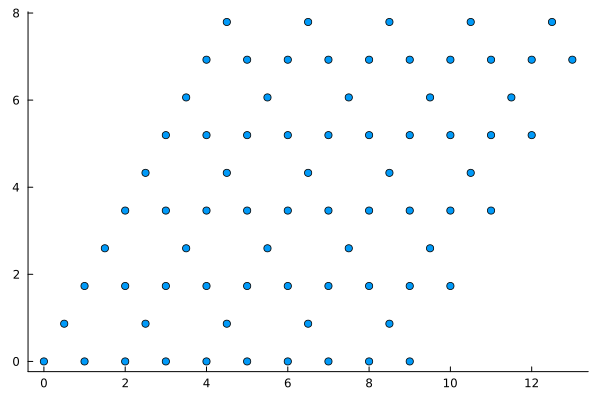

In [31]:
plot_kagome(Nx,Ny)

In [79]:
real(expect_list)[1]
# [site]

0.03276073762274579

In [125]:
# Find x and y coordinates from gicen site index

function exp_list0(site_indx)
    
    x_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[4], 1:Nx*Ny*3)
    y_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[5], 1:Nx*Ny*3)
    
    x = hcat(x_co, y_co)[site_indx, 1]
    y = hcat(x_co, y_co)[site_indx, 2] 
    exp_val = real(expect_list)[site_indx] 
    
    return x, y, exp_val
end
exp_list0(1)

(0.0, 0.0, 0.03276073762274579)

In [126]:
# Find site_index from given x and y coordinates

function exp_list1(Xx, Yy)
    co_list = hcat(x_co, y_co)
    site_indx = intersect(findall(x->x==Xx, co_list[:,1]), findall(x->x==Yy, co_list[:,2]))
    return real(expect_list)[site_indx] 
end
x_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[4], 1:Nx*Ny*3)
y_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[5], 1:Nx*Ny*3)
site_index = 5
Xx = x_co[site_index]
Yy = y_co[site_index]
print(site_index," => ",Xx,"\t",Yy," => ",exp_list1(Xx, Yy))

5 => 2.0	1.7320508075688772 => [0.037102185579949855]

In [128]:
AA = hcat(x_co, y_co)

75×2 Matrix{Any}:
  0.0  0.0
  1.0  0.0
  0.5  0.866025
  1.0  1.73205
  2.0  1.73205
  1.5  2.59808
  2.0  3.4641
  3.0  3.4641
  2.5  4.33013
  3.0  5.19615
  4.0  5.19615
  3.5  6.06218
  4.0  6.9282
  ⋮    
  9.0  1.73205
 10.0  1.73205
  9.5  2.59808
 10.0  3.4641
 11.0  3.4641
 10.5  4.33013
 11.0  5.19615
 12.0  5.19615
 11.5  6.06218
 12.0  6.9282
 13.0  6.9282
 12.5  7.79423

In [123]:
real(expect_list)

75-element Vector{Float64}:
 0.03276073762274579
 0.04964175104634896
 0.028454034061014526
 0.03513325046452836
 0.037102185579949855
 0.03251758537821768
 0.034635357606109786
 0.035283178411265465
 0.033677686721954675
 0.05108839524803562
 0.035792787409430774
 0.06533496795506316
 0.027176991952796464
 ⋮
 0.033212175305440725
 0.027362984100565025
 0.02963561890066641
 0.033951687644635804
 0.033938348942917966
 0.03737664819313876
 0.036982327360910616
 0.0433933001739482
 0.08308406198543465
 0.03443752084298732
 0.052591516657272144
 0.03580039809845233

In [135]:
Xx
Yy

75-element Vector{Any}:
 0.0
 0.0
 0.8660254037844386
 1.7320508075688772
 1.7320508075688772
 2.598076211353316
 3.4641016151377544
 3.4641016151377544
 4.330127018922193
 5.196152422706632
 5.196152422706632
 6.06217782649107
 6.928203230275509
 ⋮
 1.7320508075688772
 1.7320508075688772
 2.598076211353316
 3.4641016151377544
 3.4641016151377544
 4.330127018922193
 5.196152422706632
 5.196152422706632
 6.06217782649107
 6.928203230275509
 6.928203230275509
 7.794228634059947

In [145]:
Xx = AA[:,1];Yy = AA[:,2]
gr()
heatmap(Xx,Yy,exp_list1(Xx,Yy))

MethodError: MethodError: no method matching heatmap_edges(::Vector{Float64}, ::Symbol, ::Vector{Float64}, ::Symbol, ::Tuple{Int64}, ::Bool)
[0mClosest candidates are:
[0m  heatmap_edges(::AbstractVector, ::Symbol, ::AbstractVector, ::Symbol, [91m::Tuple{Int64, Int64}[39m, ::Bool) at C:\Users\Can\.julia\packages\Plots\8K4be\src\utils.jl:296
[0m  heatmap_edges(::AbstractVector, ::Symbol, ::AbstractVector, ::Symbol, [91m::Tuple{Int64, Int64}[39m) at C:\Users\Can\.julia\packages\Plots\8K4be\src\utils.jl:296
[0m  heatmap_edges(::AbstractVector, ::Symbol) at C:\Users\Can\.julia\packages\Plots\8K4be\src\utils.jl:286
[0m  ...

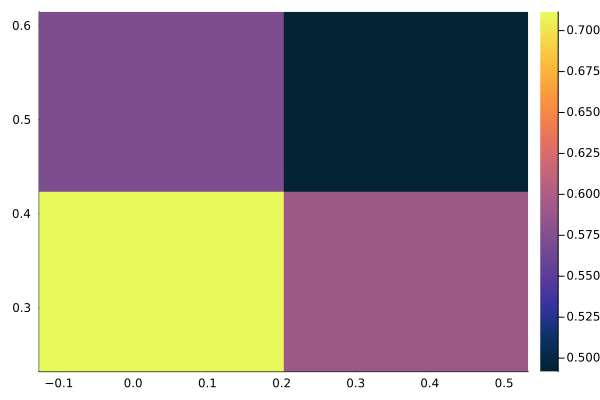

In [148]:
function f(x, y)
    r = sqrt(x^2 + y^2)
    return cos(r) / (1 + r)
end
x = sort(rand(2))
y = sort(rand(2))
heatmap(x, y, f, c = :thermal)

# Comparansion

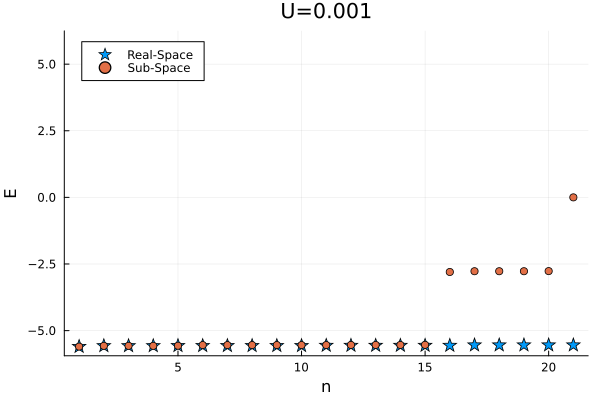

In [73]:
#U çok küçükken (Band-Gap büyüdüğünde) subspace enerjileri, real-space enerjilerine yakınsar:

using Plots

MB_Hamiltonian = Kagome_Finite_U(Nx,Ny,Basis_MB,U,sp_op)
real_space_finite_u = eigenenergies(dense(MB_Hamiltonian)); sub_space_finite_u = E_States[1]
plot(1:length(real_space_finite_u[1:21]),real_space_finite_u,seriestype=:scatter,markershape=:star5,markersize=7,label="Real-Space")
plot!(1:length(sub_space_finite_u),sub_space_finite_u,seriestype=:scatter,label="Sub-Space",legend=:topleft)
title!("U=$(U)");xlabel!("n");ylabel!("E")